In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from scipy.spatial import KDTree

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# import vortrace as vt
import Cvortrace
from vortrace.vortrace import ProjectionCloud

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [6]:
# gal0 = load_galaxy(sim0)
# gal1 = load_galaxy(sim1)
galiso = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', 120, orient=True)

In [7]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    return out

# simdata0 = extract_sim_data(gal0)
# simdata1 = extract_sim_data(gal1)
simdataiso = extract_sim_data(galiso)

In [18]:
def plot_panel(fig, ax, x, y, mass, xbins, ybins, vmin, vmax, sigma):
    dx = (xbins[-1] - xbins[0])/(len(xbins)-1)
    dy = (ybins[-1] - ybins[0])/(len(ybins)-1)

    H, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    
    H = gaussian_filter(H, sigma=0.5)
    H[H<vmin] = vmin
    
    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    return im

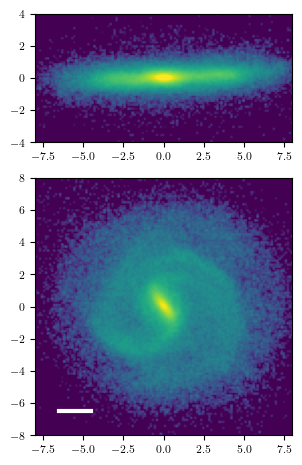

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(columnwidth, 1.4*columnwidth), height_ratios=[1,2])

L = 16
Nres = 128
vmin = 1e-4
vmax = 0.3
sigma = 2

sn = galiso.sn
pos = sn.part4.rotpos
mass = sn.part4.mass.value

xbins = np.linspace(-L/2, L/2, Nres+1)
ybins = np.linspace(-L/2, L/2, Nres+1)
zbins = np.linspace(-L/4, L/4, Nres//2+1)

im = plot_panel(fig, axs[0], pos[:,0], pos[:,2], mass, xbins, zbins, vmin, vmax, sigma)
im = plot_panel(fig, axs[1], pos[:,0], pos[:,1], mass, xbins, ybins, vmin, vmax, sigma)

# for x in axs:
    # x.set_xticks([])
    # x.set_yticks([])

axs[1].plot([-6.5, -4.5], [-6.5, -6.5], c='w', lw=3)

fig.tight_layout()

In [40]:
def get_surfdens_profile(gal):
    out = {}
    
    R = np.linalg.norm(gal.sn.part4.rotpos[:,:2], axis=1)
    mass = gal.sn.part4.mass.value
    
    is_star = gal.sn.part4.GFM_StellarFormationTime > 0
    R = R[is_star]
    mass = mass[is_star]
    
    Rlist = np.logspace(-1, 2, 1000)
    dlogR = 0.1
    
    out['aveR'] = []
    out['surf'] = []
    
    for Rmin in Rlist:
        Rmax = Rmin*(1+dlogR)
        key = np.logical_and(R >= Rmin, R < Rmax)
        area = np.pi*(Rmax**2 - Rmin**2)
        
        if np.sum(key) == 0:
            break
        
        out['aveR'].append(np.mean(R[key]))
        out['surf'].append(np.sum(mass[key])/area)
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    return out

In [41]:
out = get_surfdens_profile(galiso)

(0.0001, 1)

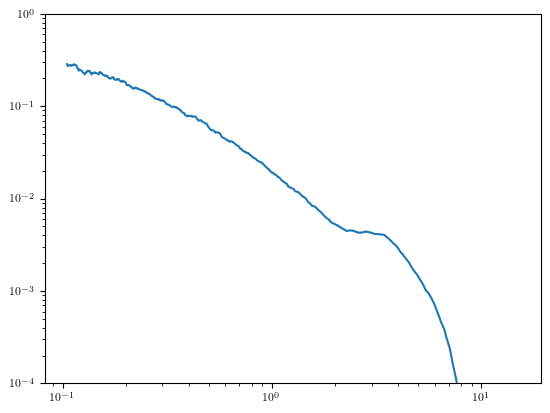

In [44]:
plt.plot(out['aveR'], out['surf'])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4, 1)

# merger plot

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [5]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [6]:
import importlib
importlib.reload(galaxy)

<module 'galaxy' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py'>

In [31]:
idx_list = np.array([40, 80, 90, 100, 200, 320])
t_list = 0.025 * idx_list
print(t_list)

gal_idx = {}
for idx in tqdm(idx_list):
    gal_idx[idx] = load_galaxy(sim0, idx=idx)

[1.   2.   2.25 2.5  5.   8.  ]


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


In [32]:
# orient wrt last idx
gal_last = gal_idx[idx_list[-1]]
gal_last.do_orient()
k, theta = gal_last.CenterOfMass.k, gal_last.CenterOfMass.theta

for idx in tqdm(idx_list[:-1]):
    gal = gal_idx[idx]
    COM, COMV, _ = gal._get_COM_COMV()
    gal._orient(COM, COMV, k, theta)

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


In [51]:
def plot_star_panel(fig, ax, gal, ix, iy):
    L = 30
    Nres = 256
    vmin = 1e-4
    vmax = 0.3
    sigma = 0.5

    sn, sub = gal.sn, gal.sub
    is_star = sn.part4.GFM_StellarFormationTime > 0
    pos = sn.part4.rotpos[is_star]
    mass = sn.part4.mass.value[is_star]

    xbins = np.linspace(-L/2, L/2, Nres+1)
    ybins = np.linspace(-L/2, L/2, Nres+1)
    zbins = np.linspace(-L/4, L/4, Nres//2+1)
    
    dx = (xbins[-1] - xbins[0])/(len(xbins)-1)
    dy = (ybins[-1] - ybins[0])/(len(ybins)-1)
    
    x = pos[:,ix]
    y = pos[:,iy]

    H, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    
    H = gaussian_filter(H, sigma=sigma)
    H[H<vmin] = vmin
    
    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    return im

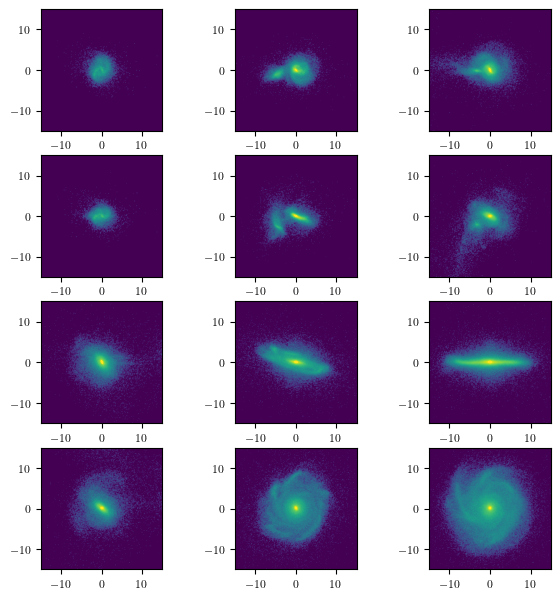

In [73]:
fig, axs = plt.subplots(4, 3, figsize=(textwidth, 0.8*textheight))

i_idx = 0
idx_list = list(gal_idx.keys())
for i in range(2):
    for j in range(3):
        idx = idx_list[i_idx]
        gal = gal_idx[idx]
        
        ax0 = axs[2*i][j]
        ax1 = axs[2*i+1][j]
        
        im0 = plot_star_panel(fig, ax0, gal, 0, 2)
        im1 = plot_star_panel(fig, ax1, gal, 0, 1)
        
        i_idx += 1

In [9]:
# def mesh_integrate(pos, rho, L, Nres):
#     # reshift box
#     pos = np.copy(pos)
#     rho = np.copy(rho)
#     pos += 3*L
#     boundbox = [0, 6*L, 0, 6*L, 0, 6*L]
#     in_box = np.full(len(pos), True)
#     for i in range(3):
#         in_box_i = np.logical_and(pos[:,i] > boundbox[2*i], pos[:,i] < boundbox[2*i+1])
#         in_box = np.logical_and(in_box, in_box_i)
    
#     pos = pos[in_box]
#     rho = rho[in_box]
#     for i in range(3):
#         print(np.max(pos[:,i]), np.min(pos[:,i]), L*3)
    
#     # print(len(pos))
#     # print(rho[:10])
    
#     print(rho[:10])
#     pc = ProjectionCloud(pos, rho, boundbox=boundbox)
#     pc._cloud.buildTree()
#     print(dir(pc._cloud))
#     # print(pc.boundbox)
    
#     dx = L/Nres
    
#     grid_points = np.linspace(-L/2+dx/2., L/2-dx/2., Nres)
#     edge_points = np.array([-L/2., L/2.])
    
#     # x-y projection
#     xv, yv, zv = np.meshgrid(grid_points, grid_points, edge_points)
#     xv = xv.flatten()
#     yv = yv.flatten()
#     zv = zv.flatten()
#     pts = np.transpose([xv, yv, zv])
#     pts_start = pts[::2] + 3*L
#     pts_end = pts[1::2] + 3*L
    
#     print(pts_start[:3])
#     print(pts_end[:3])
    
#     proj = Cvortrace.Projection(pts_start, pts_end)
#     proj.makeProjection(pc._cloud)
#     sigma_xy = proj.returnProjection()
#     # sigma_xy /= dx**2
#     # print(sigma_xy[:10])
#     sigma_xy = np.reshape(sigma_xy, (Nres, Nres))
    
#     return sigma_xy, sigma_xy
    
    
#     # x-z projection
#     xv, yv, zv = np.meshgrid(grid_points, edge_points, grid_points)
#     xv = xv.flatten()
#     yv = yv.flatten()
#     zv = zv.flatten()
#     pts = np.transpose([xv, yv, zv])
#     pts_start = pts[::2] + 3*L
#     pts_end = pts[1::2] + 3*L
    
#     proj = Cvortrace.Projection(pts_start, pts_end)
#     proj.makeProjection(pc._cloud)
#     sigma_xz = proj.returnProjection()
#     sigma_xz /= dx**2
#     sigma_xz = np.reshape(sigma_xz, (Nres, Nres))
    
#     return sigma_xy, sigma_xz

In [38]:
def mesh_integrate(pos, rho, L, Nres, Nint):
    # reshift box
    
    pos = np.copy(pos)
    rho = np.copy(rho)
    boundbox = [-1.2*L/2., 1.2*L/2., -1.2*L/2., 1.2*L/2., -1.2*L/2., 1.2*L/2.]
    in_box = np.full(len(pos), True)
    for i in range(3):
        in_box_i = np.logical_and(pos[:,i] > boundbox[2*i], pos[:,i] < boundbox[2*i+1])
        in_box = np.logical_and(in_box, in_box_i)
    
    print(np.sum(in_box)/len(in_box))
    
    pos = pos[in_box]
    rho = rho[in_box]
    
    tree = KDTree(pos)
    
    dx = L/Nres
    
    grid_points = np.linspace(-L/2+dx/2., L/2-dx/2., Nres)
    int_points = np.linspace(-L/2., L/2., Nint)
    
    # x-y projection
    xv, yv, zv = np.meshgrid(grid_points, grid_points, int_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.transpose([xv, yv, zv])

    _, indices = tree.query(pts)
    
    rho_pts = np.reshape(rho[indices], (Nres, Nres, Nint))
    sigma_xy = np.trapz(rho_pts, int_points, axis=2)
    sigma_xy /= dx**2    
    
    # x-z projection
    xv, yv, zv = np.meshgrid(grid_points, int_points, grid_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.transpose([xv, yv, zv])
    
    _, indices = tree.query(pts)
    
    rho_pts = np.reshape(rho[indices], (Nres, Nint, Nres))
    sigma_xz = np.trapz(rho_pts, int_points, axis=1)
    sigma_xz /= dx**2    
    
    return sigma_xy, sigma_xz

In [40]:
sigma_xy = {}
sigma_xz = {}

Nres = 256
L = 30

idx = 40
gal = gal_idx[idx]

sn, sub = gal.sn, gal.sub
pos = sn.part0.rotpos
rho = sn.part0.rho.value

for Nint in tqdm([100, 200, 400, 800, 1200, 1500]):
    sigma_xy[Nint], sigma_xz[Nint] = mesh_integrate(pos, rho, L, Nres, Nint)

  0%|          | 0/6 [00:00<?, ?it/s]

0.08207413096089622


 17%|█▋        | 1/6 [00:10<00:51, 10.31s/it]

0.08207413096089622


 33%|███▎      | 2/6 [00:30<01:04, 16.13s/it]

0.08207413096089622


 50%|█████     | 3/6 [01:09<01:19, 26.61s/it]

0.08207413096089622


 67%|██████▋   | 4/6 [02:25<01:32, 46.00s/it]

0.08207413096089622


 83%|████████▎ | 5/6 [04:17<01:09, 69.83s/it]

0.08207413096089622


100%|██████████| 6/6 [06:36<00:00, 66.12s/it]


In [42]:
for Nint in [100, 200, 400, 800, 1200, 1500]:
    xyerr = np.abs(sigma_xy[Nint]-sigma_xy[1500])/sigma_xy[1500]
    xymag = np.percentile(xyerr,95)
    xzerr = np.abs(sigma_xz[Nint]-sigma_xz[1500])/sigma_xz[1500]
    xzmag = np.percentile(xzerr,95)
    print(Nint, xymag, xzmag)

100 0.07437331091248199 0.7738991951041012
200 0.03831743849746022 0.28197443092144314
400 0.019539099648301625 0.2037371996191915
800 0.010811425700917584 0.05609172381152288
1200 0.008135023454070283 0.0676163821920245
1500 0.0 0.0


In [46]:
sigma_xy = {}
sigma_xz = {}

Nres = 256
Nint = 800
L = 30

for idx in tqdm(gal_idx.keys()):
    gal = gal_idx[idx]
    sn, sub = gal.sn, gal.sub
    pos = sn.part0.rotpos
    rho = sn.part0.rho.value
    
    sigma_xy[idx], sigma_xz[idx] = mesh_integrate(pos, rho, L, Nres, Nint)

  0%|          | 0/6 [00:00<?, ?it/s]

0.08207413096089622


 17%|█▋        | 1/6 [01:15<06:18, 75.68s/it]

0.09945994836117728


 33%|███▎      | 2/6 [02:31<05:02, 75.59s/it]

0.06462896358947676


 50%|█████     | 3/6 [03:46<03:46, 75.50s/it]

0.04262500114954156


 67%|██████▋   | 4/6 [04:59<02:29, 74.57s/it]

0.08594143822765361


 83%|████████▎ | 5/6 [06:17<01:15, 75.86s/it]

0.07121808095462406


100%|██████████| 6/6 [07:33<00:00, 75.62s/it]


In [69]:
def plot_gas_panel(fig, ax0, ax1, sigma_xy, sigma_xz):
    L = 30
    # Nres = 16
    # Nint = 500
    vmin = 1e-3
    vmax = 10
    # vmin = None
    # vmax = None

    # sn, sub = gal.sn, gal.sub
    # pos = sn.part0.rotpos
    # rho = 1*sn.part0.rho.value
    
    # sigma_xy, sigma_xz = mesh_integrate(pos, rho, L, Nres, Nint)
    
    extent = [-L/2., L/2., -L/2., L/2.]
    im0 = ax0.imshow(sigma_xz.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    im1 = ax1.imshow(sigma_xy.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    return im0, im1

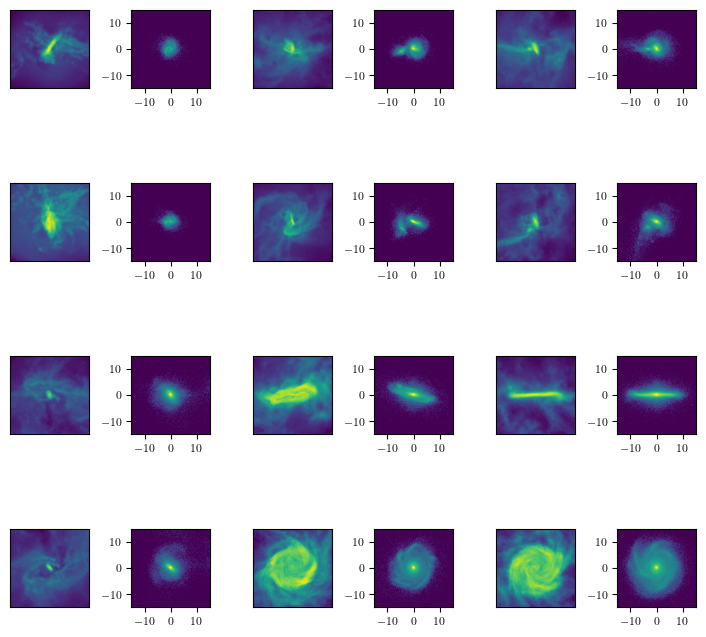

In [53]:
fig, axs = plt.subplots(4, 6, figsize=(textwidth, 0.8*textheight))

i_idx = 0
idx_list = list(gal_idx.keys())
for i in range(2):
    for j in range(3):
        idx = idx_list[i_idx]
        gal = gal_idx[idx]
        
        ax0 = axs[2*i][2*j]
        ax1 = axs[2*i+1][2*j]
        
        im0, im1 = plot_gas_panel(fig, ax0, ax1, sigma_xy[idx], sigma_xz[idx])
        
        ax0.set(xticks=[], yticks=[])
        ax1.set(xticks=[], yticks=[])
        
        ax0 = axs[2*i][2*j+1]
        ax1 = axs[2*i+1][2*j+1]
        
        im0 = plot_star_panel(fig, ax0, gal, 0, 2)
        im1 = plot_star_panel(fig, ax1, gal, 0, 1)
        
        i_idx += 1

fig.tight_layout()
fig.savefig('gas.pdf')

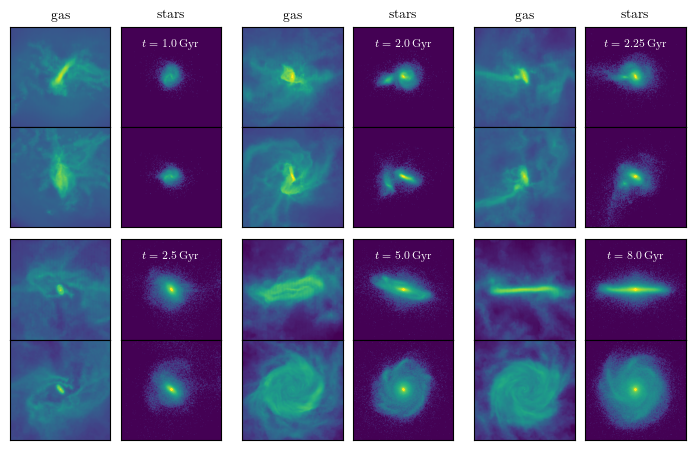

In [85]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(textwidth, 0.5*textheight))
outer = gridspec.GridSpec(2, 3)

idx_list = list(gal_idx.keys())

for i in range(6):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0, hspace=0)
    idx = idx_list[i]
    gal = gal_idx[idx]
    
    ax0 = plt.Subplot(fig, inner[0])
    ax1 = plt.Subplot(fig, inner[2])
    
    im0, im1 = plot_gas_panel(fig, ax0, ax1, sigma_xy[idx], sigma_xz[idx])
    # print(im0.get_clim(), im1.get_clim())
        
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    if i < 3:
        ax0.set_title(r'$\textrm{gas}$')
        
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)
        
    ax0 = plt.Subplot(fig, inner[1])
    ax1 = plt.Subplot(fig, inner[3])
        
    im0 = plot_star_panel(fig, ax0, gal, 0, 2)
    im1 = plot_star_panel(fig, ax1, gal, 0, 1)
    
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    tstr = str(round(gal.sn.Time.value, 2))
    ax0.text(0, 9, r'$t='+tstr+r'\,\textrm{Gyr}$', c='w', fontsize=8, ha='center')
    
    if i < 3:
        ax0.set_title(r'$\textrm{stars}$')
    
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)

fig.tight_layout()
fig.savefig('surfdens.pdf')